In [1]:
import os
import time
import sys
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.backends import cudnn
from torch.nn import functional as F

from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

import load_so_data as so_data
import main as explor
import models
# import utils
import main

import importlib as imp
imp.reload(models)
# imp.reload(utils)
imp.reload(main)
imp.reload(so_data)
# Define data root directory

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
# Parameters
params = {'batch_size': 256, 'shuffle': True, 'num_workers': 6}
max_epochs = 25

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

window_len = 5*7

common_params = {
    'window_length': window_len,
    'badge_focus': 'Electorate',
    'out_dim': 'QuestionVotes',
    'data_path': '../data'
}

dset_train = so_data.StackOverflowDataset(dset_type='train', subsample=4000, 
                                             **common_params)
dset_test = so_data.StackOverflowDataset(dset_type='test', subsample=1000, 
                                             **common_params)
dset_valid = so_data.StackOverflowDataset(dset_type='validate', subsample=1000, centered=True,
                                             **common_params)

train_loader = DataLoader(dset_train, **params)
test_loader = DataLoader(dset_test, **params)
valid_loader = DataLoader(dset_valid, **params)

In [5]:
len(valid_loader.dataset)

1000

# Motivation

We extend the theoretical model from <b>Steering User Behavior with Badges</b> to one that is grounded in the users' behaviour on Stack Overflow. From the model, we learn some insights about how people act in the presence of a badge and how they repond to badge incentives.


**Original model:**

$$
U(x_a) = \sum\limits_{b \in B} I_b(a) V_b + \theta \sum\limits_{i=1}^{n+1}x_a^i \cdot U(x_{a+e_i}) - g(x_a, \mathbf{p}) 
$$

The probability of acting depends on:

1. The user specific base distribution ($\mathbf{p}$).
2. The value of a badge (not specified if this is user specific or assumed external to the user) ($V_b$).
3. The cost that a user pays for deviating from the base distribution ($g$).
4. (some discount parameter $\theta$)

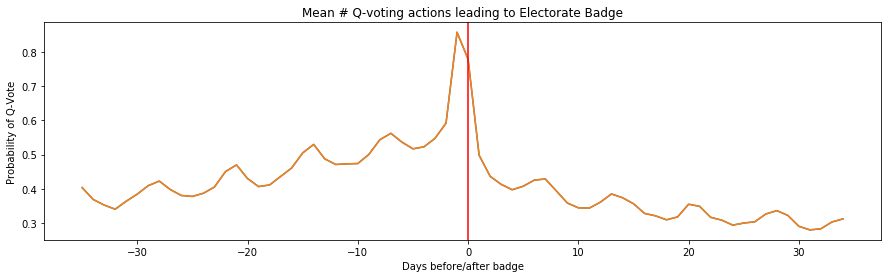

In [6]:
s = np.concatenate([seq.numpy() for seq, kernel, out, prox, badge_date in train_loader], axis=0)
o = np.concatenate([out.numpy() for seq, kernel, out, prox, badge_date in train_loader], axis=0)

plt.figure(figsize=(15,4))
plt.plot(np.arange(-5*7, 5*7), np.mean(s[:,:,5], axis=0))
plt.plot(np.arange(-5*7, 5*7), np.mean(o, axis=0))
plt.axvline(0, c='red')
plt.title('Mean # Q-voting actions leading to Electorate Badge')
plt.xlabel('Days before/after badge')
plt.ylabel('Probability of Q-Vote')

plt.show()

### Express as a graphical model 

From the model, a user will only deviate if the badge value outweighs the cost of changing his/her default behaviour.

It follows that (2) and (3) can be understood as a deviation from the user's base distribution as the user approaches the badge boundary. This deviation is non-negative before the badge is achieved and non-positive after the badge has been achieved.

**A simplifying assumptions:** the ''badge deviation'' (called kernel from now on) is a function that depends on the user's proximity to the badge and is a shared response between all users. This assumption can be relaxed at a later stage.

We obtain the following graphical model for a user's interaction behaviour (p is the base distribution local to a user and $\beta$ is the badge kernel:

![img1](images/img1.png)

###  Address Weaknesses of baseline model:

1. There is evidence that users do not respond uniformly to the badge. **Solution**: add a user-specific parameter that controls the strength of the effect of the badge response (shown below). $S \in (0,1)$ is the parameter that controls the strenth of a user's adherence to the kernel. P and S are both local latent variables, specific to each user.  

![img2](images/img2.png)

2. It is possible that users do not respond with the same functional form to a badge (not addressed yet).

In [7]:
proximity = []
s = []
for seq, kernel, out, prox, badge_date in train_loader:
    s.append(seq.numpy())
    proximity.append(prox.numpy())
    
proximity = np.concatenate(proximity, axis=0)
s = np.concatenate(s, axis=0)

s.shape, proximity.shape

((4000, 70, 7), (4000, 70))

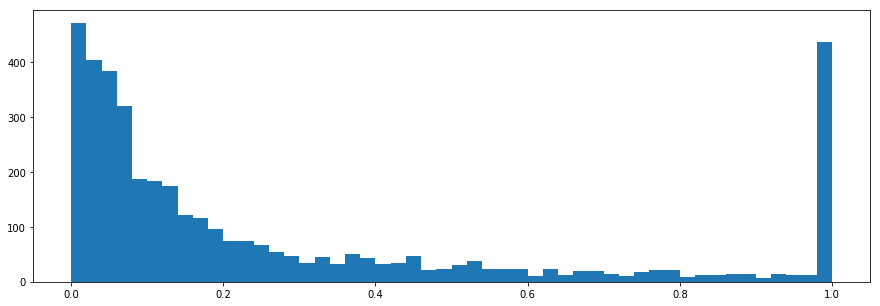

In [8]:
plt.figure(figsize=(15,5))
plt.hist(proximity[:,5*7], bins=50)
plt.show()

# Brief motivation for strength parameter (S):

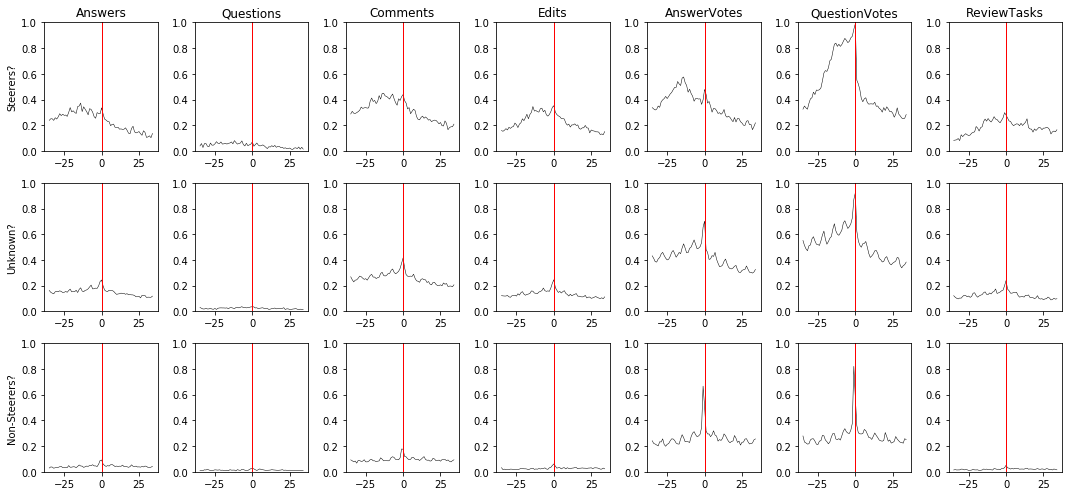

In [9]:
fig, axes = plt.subplots(3,7, figsize=(15,7))

for i in range(7):
    for j in range(3):
        mask = proximity[:,5*7] <= .1
        if j == 0:
            mask = proximity[:,5*7] > .9
        elif j == 1:
            mask = (proximity[:,5*7] <= .9) & (proximity[:,5*7] > .1)
            
        axes[j,i].plot(
                np.arange(-len(proximity[0])//2,len(proximity[0])//2),
                np.mean(s[mask,:,i], axis=0)
            , lw=.5, c='black')
        axes[j,i].axvline(0, c='red', lw=1)
        axes[j,i].set_ylim([0,1])
        
    axes[0,i].set_title(so_data.ACTIONS[i])
    
axes[0,0].set_ylabel('Steerers?')
axes[1,0].set_ylabel('Unknown?')
axes[2,0].set_ylabel('Non-Steerers?')

plt.tight_layout()
plt.show()

## Notes:
    
- Different populations have different responses to the badge in the proximity of the badge.
    
- The population that starts with the lowest count of actions (in the 5 week period) has the biggest deviance from 0 in their response

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

In [11]:
def test(model, loss_fn, get_latent_par=[]):
    latent_pars = {}
    latent_pars['steered'] = []
    latent_pars['not_steered'] = []
    with torch.set_grad_enabled(False):
        validation_loss = 0
        for val_in, kernel_data, val_out, val_prox, badge_date in test_loader:
            # Transfer to GPU
            val_in, kernel_data, val_out, val_prox, badge_date = val_in.to(device), \
                            kernel_data.to(device), val_out.to(device), val_prox.to(device), badge_date.to(device)
            # Model computations
            # Model computations
            recon_batch, mu, logvar = model(val_in, kernel_data=kernel_data, dob=badge_date, prox_to_badge=val_prox)

            loss = loss_fn(recon_batch, val_out, mu, logvar)
            validation_loss += loss.item()

            for user_prox, user_mu in zip(val_prox.detach().numpy(), mu.detach().numpy()):
                if np.max(user_prox) > .70:
                    latent_pars['steered'].append(user_mu[-1])
                elif np.max(user_prox) < .1:
                    latent_pars['not_steered'].append(user_mu[-1])
            for p in get_latent_par:
                if p not in latent_pars:
                    latent_pars[p] = []
                latent_pars[p] += [float(mu_.numpy()) for mu_ in mu[:,p]]
        print('Average Test loss: {:.4f}'.format(validation_loss/len(valid_loader.dataset)))
    return latent_pars

In [12]:
dset_shape = dset_train.__getitem__(0)[0].size()
params = {
    'device': device,
    'proximity_to_badge': True
}

In [13]:
def plot_kernel(dset, model, dset_shape, device, ax=None, title=""):
    val_in, kernel_data, val_out, val_prox, badge_date = dset.__getitem__(0)
    val_in, kernel_data, val_out, val_prox, badge_date = val_in.reshape(-1,dset_shape[0],dset_shape[1]).to(device), \
                        kernel_data.reshape(-1,dset_shape[0]).to(device), \
                        val_out.reshape(-1,dset_shape[0]).to(device),     \
                        val_prox.reshape(-1,dset_shape[0]).to(device),    \
                        badge_date.reshape(-1,).to(device)
    
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize=(15,5)) 
        
    recon_batch, mu, logvar = model(val_in, kernel_data=kernel_data, dob=badge_date, prox_to_badge=val_prox)
    k = model.kernel(mu, val_in, kernel_data=kernel_data)
    for k_ in k:
        ax.plot(np.arange(-5*7, 5*7), k_.detach().numpy(), alpha=1)

    ax.axvline(x=0, lw=.5, ls='--', color='black')
    ax.axhline(y=0, lw=.5, ls='--', color='black')
    ax.set_ylim([-5,5])
    title = model.__class__ if len(title)==0 else title
    ax.set_title(title)
    
    ax.set_xlabel('Days before/after badge')
    ax.set_ylabel('Log-odds change acting probability')
        
    return ax

<hr />

<hr />

# Method 

Compare and contrast the models, investigate the functional form of the steering kernel and relax modeling assumptions.

## Baseline (model 1)
Model assumptions:
    
(1) Every user has their own "base distribution".

(2) Base distribution does not change between weeks of interaction.

![img3](images/img3.png)

In [14]:
model_base = models.BaselineVAE(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/baseline.pt'
model_base.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [15]:
loss_fn = lambda x1,x2,x3,x4: models.BCE_loss_function(x1,x2,x3,x4, data_shape=dset_shape, act_choice=5)
_ = test(model_base, loss_fn)

Average Test loss: 40.6902


## Linear parameter (model 2)

Model assumptions:
    
(1) Every user has their own "base distribution".

(2) Base distribution does not change between weeks of interaction.

(3) All users experience a linear strictly positive change in probability of acting as they approach the badge boundary. Thereafter they experience a non-positive change in probability in acting. 

![img1](images/img1.png)

In [16]:
model_lin = models.LinearParametricVAE(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/linear.pt'
model_lin.load_state_dict(torch.load(PATH, map_location=device))
model = model_lin

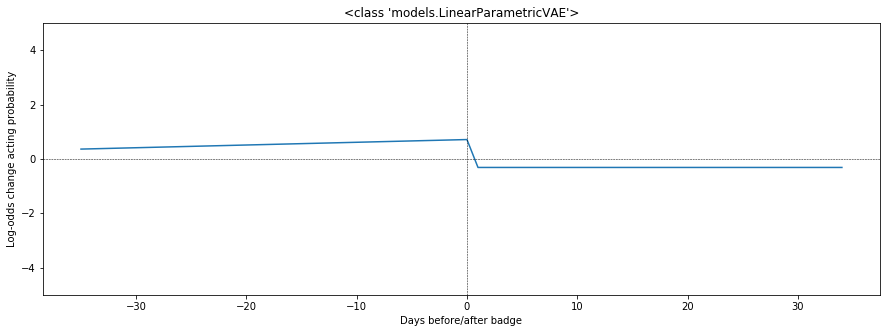

In [17]:
plot_kernel(dset_train, model, dset_shape, device)

In [18]:
loss_fn = lambda x1,x2,x3,x4: models.BCE_loss_function(x1,x2,x3,x4, data_shape=dset_shape, act_choice=5)
_ = test(model, loss_fn)

Average Test loss: 40.0251


## Personalised Linear (model 3)
Model assumptions - same as Linear but:
    
1) A user-specific steering parameter $\in (0,1)$ that controls the effect of the deviance from normal acting.

![img2](images/img2.png)

In [19]:
model_per_lin = models.LinearParametricPlusSteerParamVAE(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/personalised_linear.pt'
model_per_lin.load_state_dict(torch.load(PATH, map_location=device))
model = model_per_lin

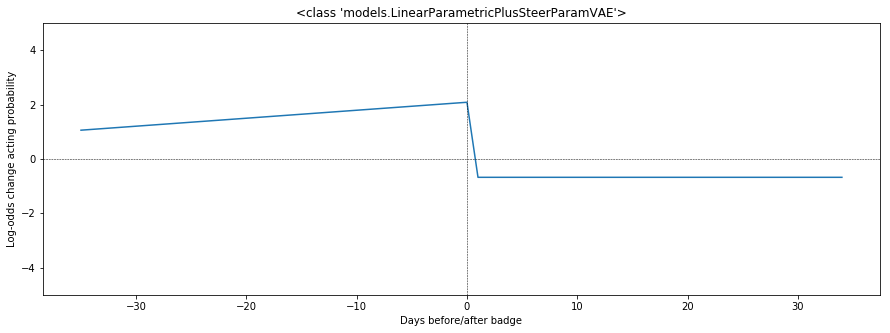

In [20]:
plot_kernel(dset_train, model, dset_shape, device)

In [21]:
loss_fn = lambda x1,x2,x3,x4: models.BCE_loss_function(x1,x2,x3,x4, data_shape=dset_shape, act_choice=5)
ladent_dim = test(model, loss_fn, get_latent_par=[19])

Average Test loss: 39.1568


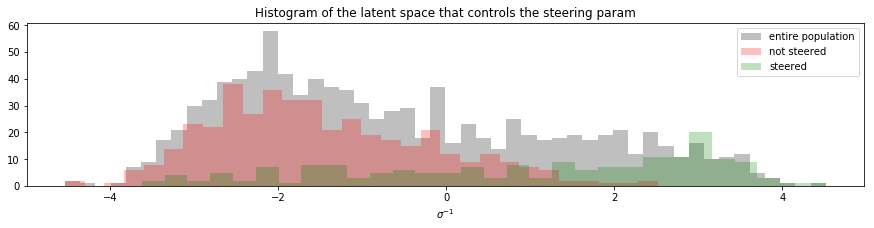

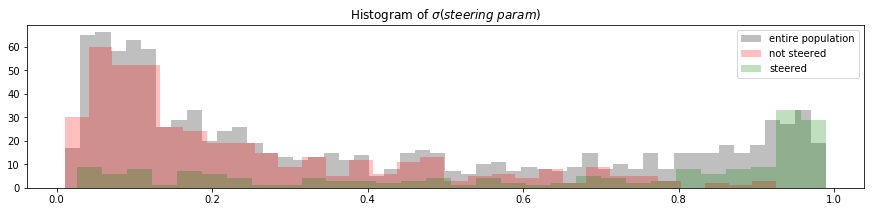

In [22]:
sigmoid = lambda x: np.exp(x)/(1+np.exp(x))
w = model.positive_steer_weight[0].detach().numpy()

plt.figure(figsize=(15,3))
plt.hist(w*ladent_dim[19], label='entire population', bins=50, alpha=.5, color='grey')
plt.hist(w*ladent_dim['not_steered'], label='not steered', alpha=.25, color='red', bins=30)
plt.hist(w*ladent_dim['steered'], label='steered', alpha=.25, color='green', bins=30)
plt.legend(loc='best')
plt.title('Histogram of the latent space that controls the steering param')
plt.xlabel("$\sigma^{-1}$")
plt.show()

plt.figure(figsize=(15,3))
plt.hist(sigmoid(w*ladent_dim[19]), label='entire population', bins=50, alpha=.5, color='grey')
plt.hist(sigmoid(w*ladent_dim['not_steered']), label='not steered', alpha=.25, color='red', bins=30)
plt.hist(sigmoid(w*ladent_dim['steered']), label='steered', alpha=.25, color='green', bins=30)
plt.legend(loc='best')
plt.title('Histogram of $\sigma(steering\ param)$')
plt.show()

# Fully parameterised (model 4)

Model assumptions:
    

(1) Every user has their own "base distribution".

(2) Base distribution does not change between weeks of interaction.

(3) All users experience a non-negative change in probability of acting before the badge is achieved and a non-positive change in probability of acting before the badge is achieved.


In [23]:
model_fp = models.FullParameterisedVAE(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/full_parameterised.pt'
model_fp.load_state_dict(torch.load(PATH, map_location=device))
model = model_fp

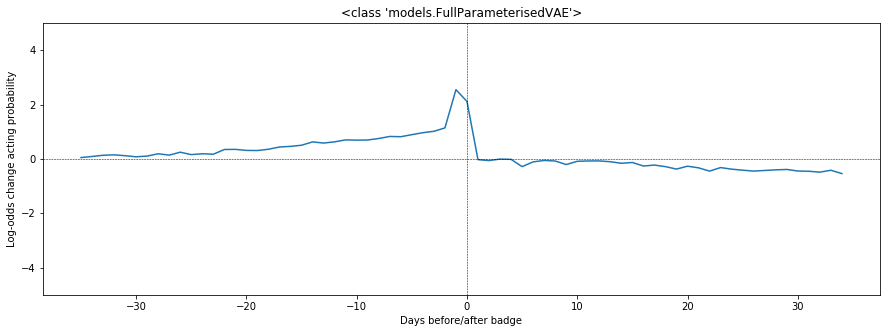

In [24]:
plot_kernel(dset_train, model, dset_shape, device)

In [25]:
loss_fn = lambda x1,x2,x3,x4: models.BCE_loss_function(x1,x2,x3,x4, data_shape=dset_shape, act_choice=5)
_ = test(model, loss_fn)

Average Test loss: 38.8903


# Fully parameterised, personal param (model 5)
Model assumptions - same as full parameterised but:
    
1) A user-specific steering parameter $\in (0,1)$ that controls the effect of the deviance from normal acting.

In [26]:
model_per_fp = models.FullParameterisedPlusSteerParamVAE(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/full_personalised_parameterised.pt'
model_per_fp.load_state_dict(torch.load(PATH, map_location=device))
model = model_per_fp

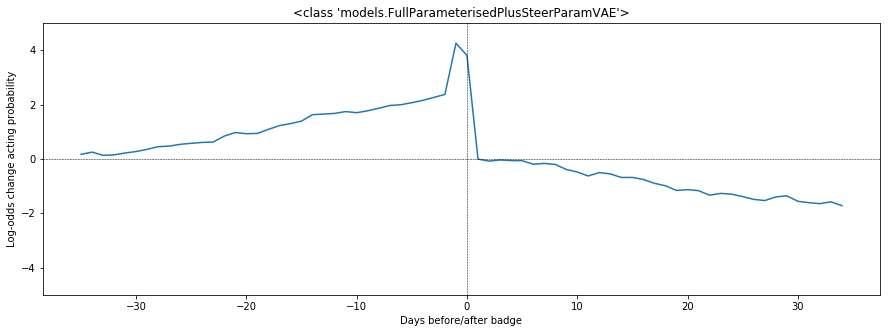

In [27]:
plot_kernel(dset_train, model, dset_shape, device)

In [28]:
loss_fn = lambda x1,x2,x3,x4: models.BCE_loss_function(x1,x2,x3,x4, data_shape=dset_shape, act_choice=5)
ladent_dim = test(model, loss_fn, get_latent_par=[19])

Average Test loss: 38.3979


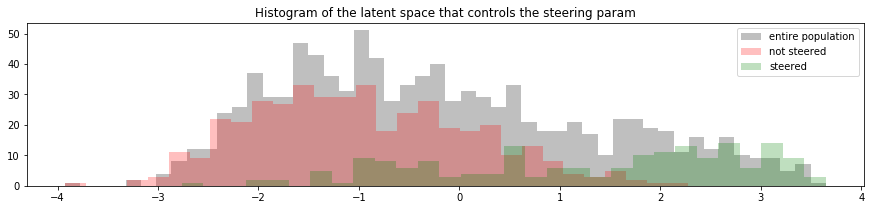

In [29]:
w = model.positive_steer_weight[0].detach().numpy()

plt.figure(figsize=(15,3))
plt.hist(w*ladent_dim[19], label='entire population', bins=50, alpha=.5, color='grey')
plt.hist(w*ladent_dim['not_steered'], label='not steered', alpha=.25, color='red', bins=30)
plt.hist(w*ladent_dim['steered'], label='steered', alpha=.25, color='green', bins=30)
plt.legend(loc='best')
plt.title('Histogram of the latent space that controls the steering param')
plt.show()

# Flexible Linear Parametric

In [30]:
model = models.FlexibleLinearParametricVAE(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/flexible_linear.pt'
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [31]:
model.badge_param

Parameter containing:
tensor([-6.4769, -1.1331, -6.4772, -1.0799,  1.5088,  1.5249],
       requires_grad=True)

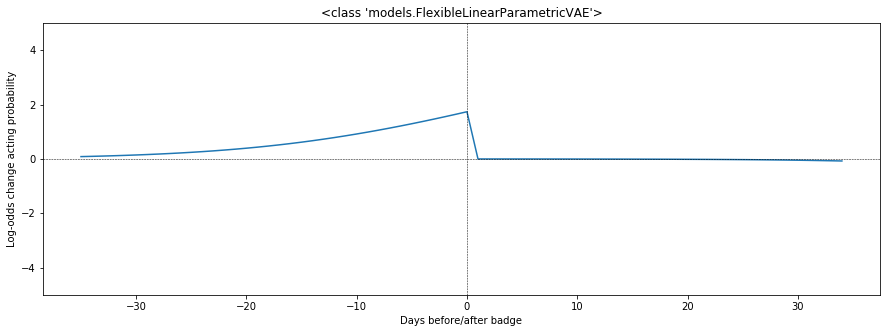

In [32]:
plot_kernel(dset_train, model, dset_shape, device)

In [33]:
loss_fn = lambda x1,x2,x3,x4: models.BCE_loss_function(x1,x2,x3,x4, data_shape=dset_shape, act_choice=5)
ladent_dim = test(model, loss_fn, get_latent_par=[19])

Average Test loss: 39.4198


# Personalised Flexible Linear

In [34]:
model = models.FlexibleLinearPlusSteerParamVAE(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/personalised_flexible_linear.pt'
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

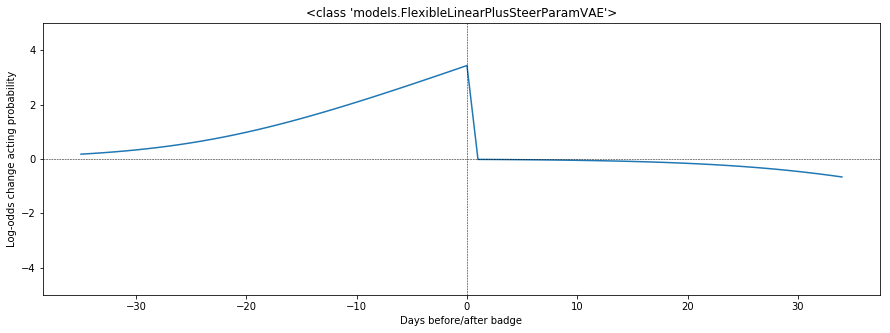

In [35]:
plot_kernel(dset_train, model, dset_shape, device)

In [36]:
loss_fn = lambda x1,x2,x3,x4: models.BCE_loss_function(x1,x2,x3,x4, data_shape=dset_shape, act_choice=5)
ladent_dim = test(model, loss_fn, get_latent_par=[19])

Average Test loss: 39.1957


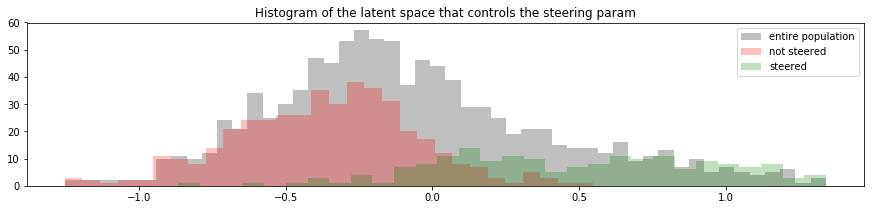

In [37]:
w = model.positive_steer_weight[0].detach().numpy()

plt.figure(figsize=(15,3))
plt.hist(w*ladent_dim[19], label='entire population', bins=50, alpha=.5, color='grey')
plt.hist(w*ladent_dim['not_steered'], label='not steered', alpha=.25, color='red', bins=30)
plt.hist(w*ladent_dim['steered'], label='steered', alpha=.25, color='green', bins=30)
plt.legend(loc='best')
plt.title('Histogram of the latent space that controls the steering param')
plt.show()

# Compare the results:

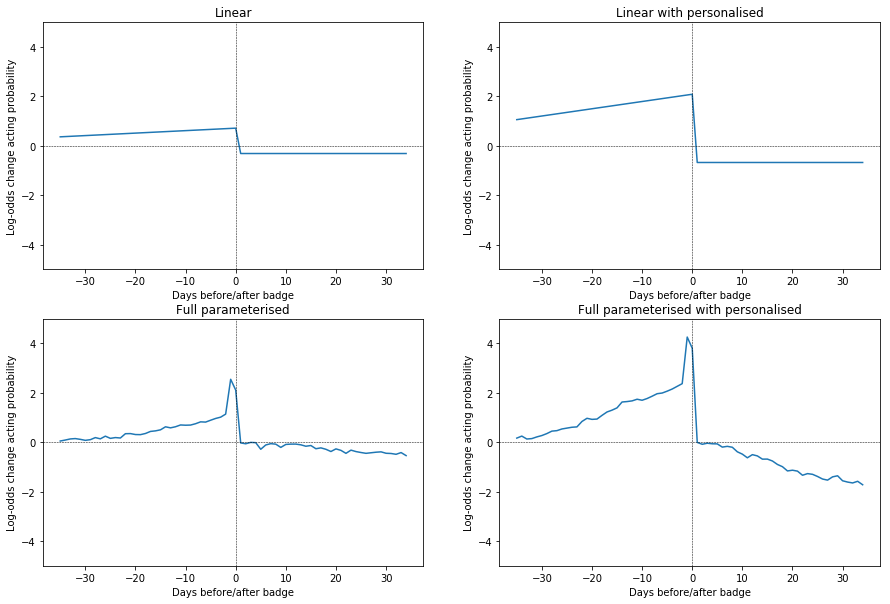

In [38]:
# compare kernels
fig, axes = plt.subplots(2,2,figsize=(15,10))
axes = axes.flatten()
mdls = [model_lin, model_per_lin, model_fp, model_per_fp]
title = ['Linear', 'Linear with personalised', 'Full parameterised', 'Full parameterised with personalised']
for i, m in enumerate(mdls):
    plot_kernel(dset_train, m, dset_shape, device, ax=axes[i], title=title[i])
plt.show()

In [39]:
# compare loss
print("Baseline: \t\t", end='')
ladent_dim = test(model_base, loss_fn, get_latent_par=[19])
print("Linear: \t\t", end='')
ladent_dim = test(model_lin, loss_fn, get_latent_par=[19])
print("Linear + Personalised: \t", end='')
ladent_dim = test(model_per_lin, loss_fn, get_latent_par=[19])
print("Full P: \t\t", end='')
ladent_dim = test(model_fp, loss_fn, get_latent_par=[19])
print("Full P + Personalised: \t", end='')
ladent_dim = test(model_per_fp, loss_fn, get_latent_par=[19])

Baseline: 		Average Test loss: 40.7239
Linear: 		Average Test loss: 39.8973
Linear + Personalised: 	Average Test loss: 39.0458
Full P: 		Average Test loss: 38.8870
Full P + Personalised: 	Average Test loss: 38.3837


# Next Steps

## Study the trajectories of the inferences from Full-parameterised model:

In [40]:
latent_pars = {}
latent_pars['steered'] = []
latent_pars['not_steered'] = []
latent_pars['unknown'] = []

with torch.set_grad_enabled(False):
    validation_loss = 0
    for val_in, kernel_data, val_out, val_prox, badge_date in test_loader:
        # Transfer to GPU
        val_in, kernel_data, val_out, val_prox, badge_date = val_in.to(device), \
                        kernel_data.to(device), val_out.to(device), val_prox.to(device), badge_date.to(device)
        # Model computations
        # Model computations
        recon_batch, mu, logvar = model(val_in, kernel_data=kernel_data, dob=badge_date, prox_to_badge=val_prox)

        loss = loss_fn(recon_batch, val_out, mu, logvar)
        validation_loss += loss.item()

        for user_out, user_mu in zip(val_out.detach().numpy(), mu.detach().numpy()):
            if np.max(user_mu[-1]) > .5:
                latent_pars['steered'].append(user_out)
            elif np.max(user_mu[-1]) < -.5:
                latent_pars['not_steered'].append(user_out)
            else:
                latent_pars['unknown'].append(user_out)

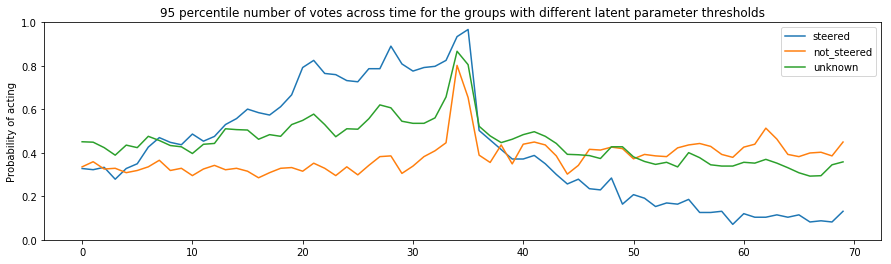

In [41]:
trajs = np.array(latent_pars['steered'])
trajs2 = np.array(latent_pars['not_steered'])
trajs3 = np.array(latent_pars['unknown'])

plt.figure(figsize=(15,4))
plt.plot(np.mean(trajs, axis=0),  label='steered')
plt.plot(np.mean(trajs2, axis=0), label='not_steered')
plt.plot(np.mean(trajs3, axis=0), label='unknown')
plt.title('95 percentile number of votes across time for the groups with different latent parameter thresholds')
plt.legend(loc='best')
plt.ylim([0,1])
plt.ylabel('Probability of acting')
plt.show()